# Testing New Experiment API

Load data.

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Load assays and utility functions.

In [2]:
import os

def get_tcp_objectives():

    dockstring_dir = f'{path}/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
    from dgym.envs.utility import ClassicUtilityFunction

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    
    return pIC50_oracle, log_P_oracle, log_S_oracle

In [3]:
from dgym.envs.utility import ClassicUtilityFunction, MultipleUtilityFunction

# Get objectives
pIC50_oracle, log_P_oracle, log_S_oracle = get_tcp_objectives()

# Define utility functions
pIC50_utility = ClassicUtilityFunction(
    pIC50_oracle, ideal=(9.5, 13), acceptable=(8, 13))
log_P_utility = ClassicUtilityFunction(
    log_P_oracle, ideal=(0.5, 1.85), acceptable=(-0.5, 3.5))
log_S_utility = ClassicUtilityFunction(
    log_S_oracle, ideal=(-3, 1), acceptable=(-4, 1))

# Assemble assays and surrogate models
assays = [
    pIC50_oracle,
    log_P_oracle,
    log_S_oracle,
    pIC50_oracle.surrogate(sigma=1.0),
    log_P_oracle.surrogate(sigma=1.0),
    log_S_oracle.surrogate(sigma=1.0),
]

# Environment tolerates acceptable ADMET
from copy import deepcopy
utility_agent = MultipleUtilityFunction(
    utility_functions = [pIC50_utility, log_P_utility, log_S_utility],
    weights = [0.8, 0.1, 0.1]
)
utility_env = deepcopy(utility_agent)
utility_env.utility_functions[1].ideal = utility_env.utility_functions[1].acceptable
utility_env.utility_functions[2].ideal = utility_env.utility_functions[2].acceptable

Instantiate designer.

In [4]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [15]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
library = dg.MoleculeCollection(initial_molecules).update_annotations()

# Score molecules
for assay in assays:
    if 'Noisy' not in assay.name:
        results = assay(library)
        for molecule, result in zip(library, results):
            molecule.update_annotations({assay.name: result})

# Set status to tested
library.set_status('Tested', step=0)

Instantiate Environment and Agent.

In [32]:
from dgym.envs import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

drug_env = DrugEnv(
    designer = designer,
    library = library,
    assays = assays,
    utility_function = utility_env
)

# Construct sequence
design_grow = {'name': 'design', 'batch_size': 5, 'parameters': {'strategy': 'grow', 'size': 8}}
design_replace = {'name': 'design', 'batch_size': 5, 'parameters': {'strategy': 'replace', 'size': 8, 'temperature': 0.2}}
score = {'name': ['Noisy ABL1 pIC50', 'Noisy Log S', 'Noisy Log P'], 'batch_size': 40}
make = {'name': 'make', 'batch_size': 8}
test = {'name': ['ABL1 pIC50', 'Log S', 'Log P'], 'batch_size': 8} # 8
design_and_score = [design_replace, score]

sequence = [*(design_and_score * 1), design_grow, score, make, test]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    exploration_strategy = EpsilonGreedy(epsilon=0.2),
    utility_function = utility_agent
)

In [33]:
def display_best(experiment):
    import numpy as np
    observations = experiment.drug_env.library
    utilities = experiment.drug_env.utility_function(
        observations, use_precomputed=True, method='average')
    for obs, utility in zip(observations, utilities):
        obs.update_annotations({'utility': utility})
    tested = observations.tested
    if tested:
        best_tested = (
            tested
            .annotations
            .sort_values('utility', ascending=False)
            [['ABL1 pIC50', 'Log S', 'Log P', 'utility']]
            .head()
        )
        display(best_tested)

In [35]:
from dgym.experiment import Experiment

experiment = Experiment(
    drug_env=drug_env,
    drug_agent=drug_agent
)

result = experiment.run()

In [39]:
import seaborn as sns
experiment.drug_env.library.tested.annotations.reindex(
    columns=[*drug_env.assays, 'Current Status', 'Step Designed', 'Step Scored', 'Step Made', 'Step Tested'])

,ABL1 pIC50,Log P,Log S,Noisy ABL1 pIC50,Noisy Log P,Noisy Log S,Current Status,Step Designed,Step Scored,Step Made,Step Tested
0,5.850960,1.5379,-1.091122,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
1,1.526783,1.7028,-3.147196,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
2,6.778515,2.7256,-3.184914,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
3,7.338496,1.6914,-1.854250,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
4,5.242725,-1.5626,-0.974548,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
632,9.489531,2.6659,-5.190893,9.215272,3.002297,-4.686732,Tested,8.0,8.0,9.0,9
633,8.150334,2.9051,-3.472234,8.668231,1.474619,-3.337195,Tested,8.0,8.0,9.0,9
649,8.208042,4.0662,-4.077315,9.416033,4.438679,-2.576765,Tested,8.0,8.0,9.0,9
657,8.690234,4.4716,-4.462902,9.750178,3.783177,-3.542051,Tested,8.0,8.0,9.0,9


/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

<Figure size 1920x1440 with 0 Axes>

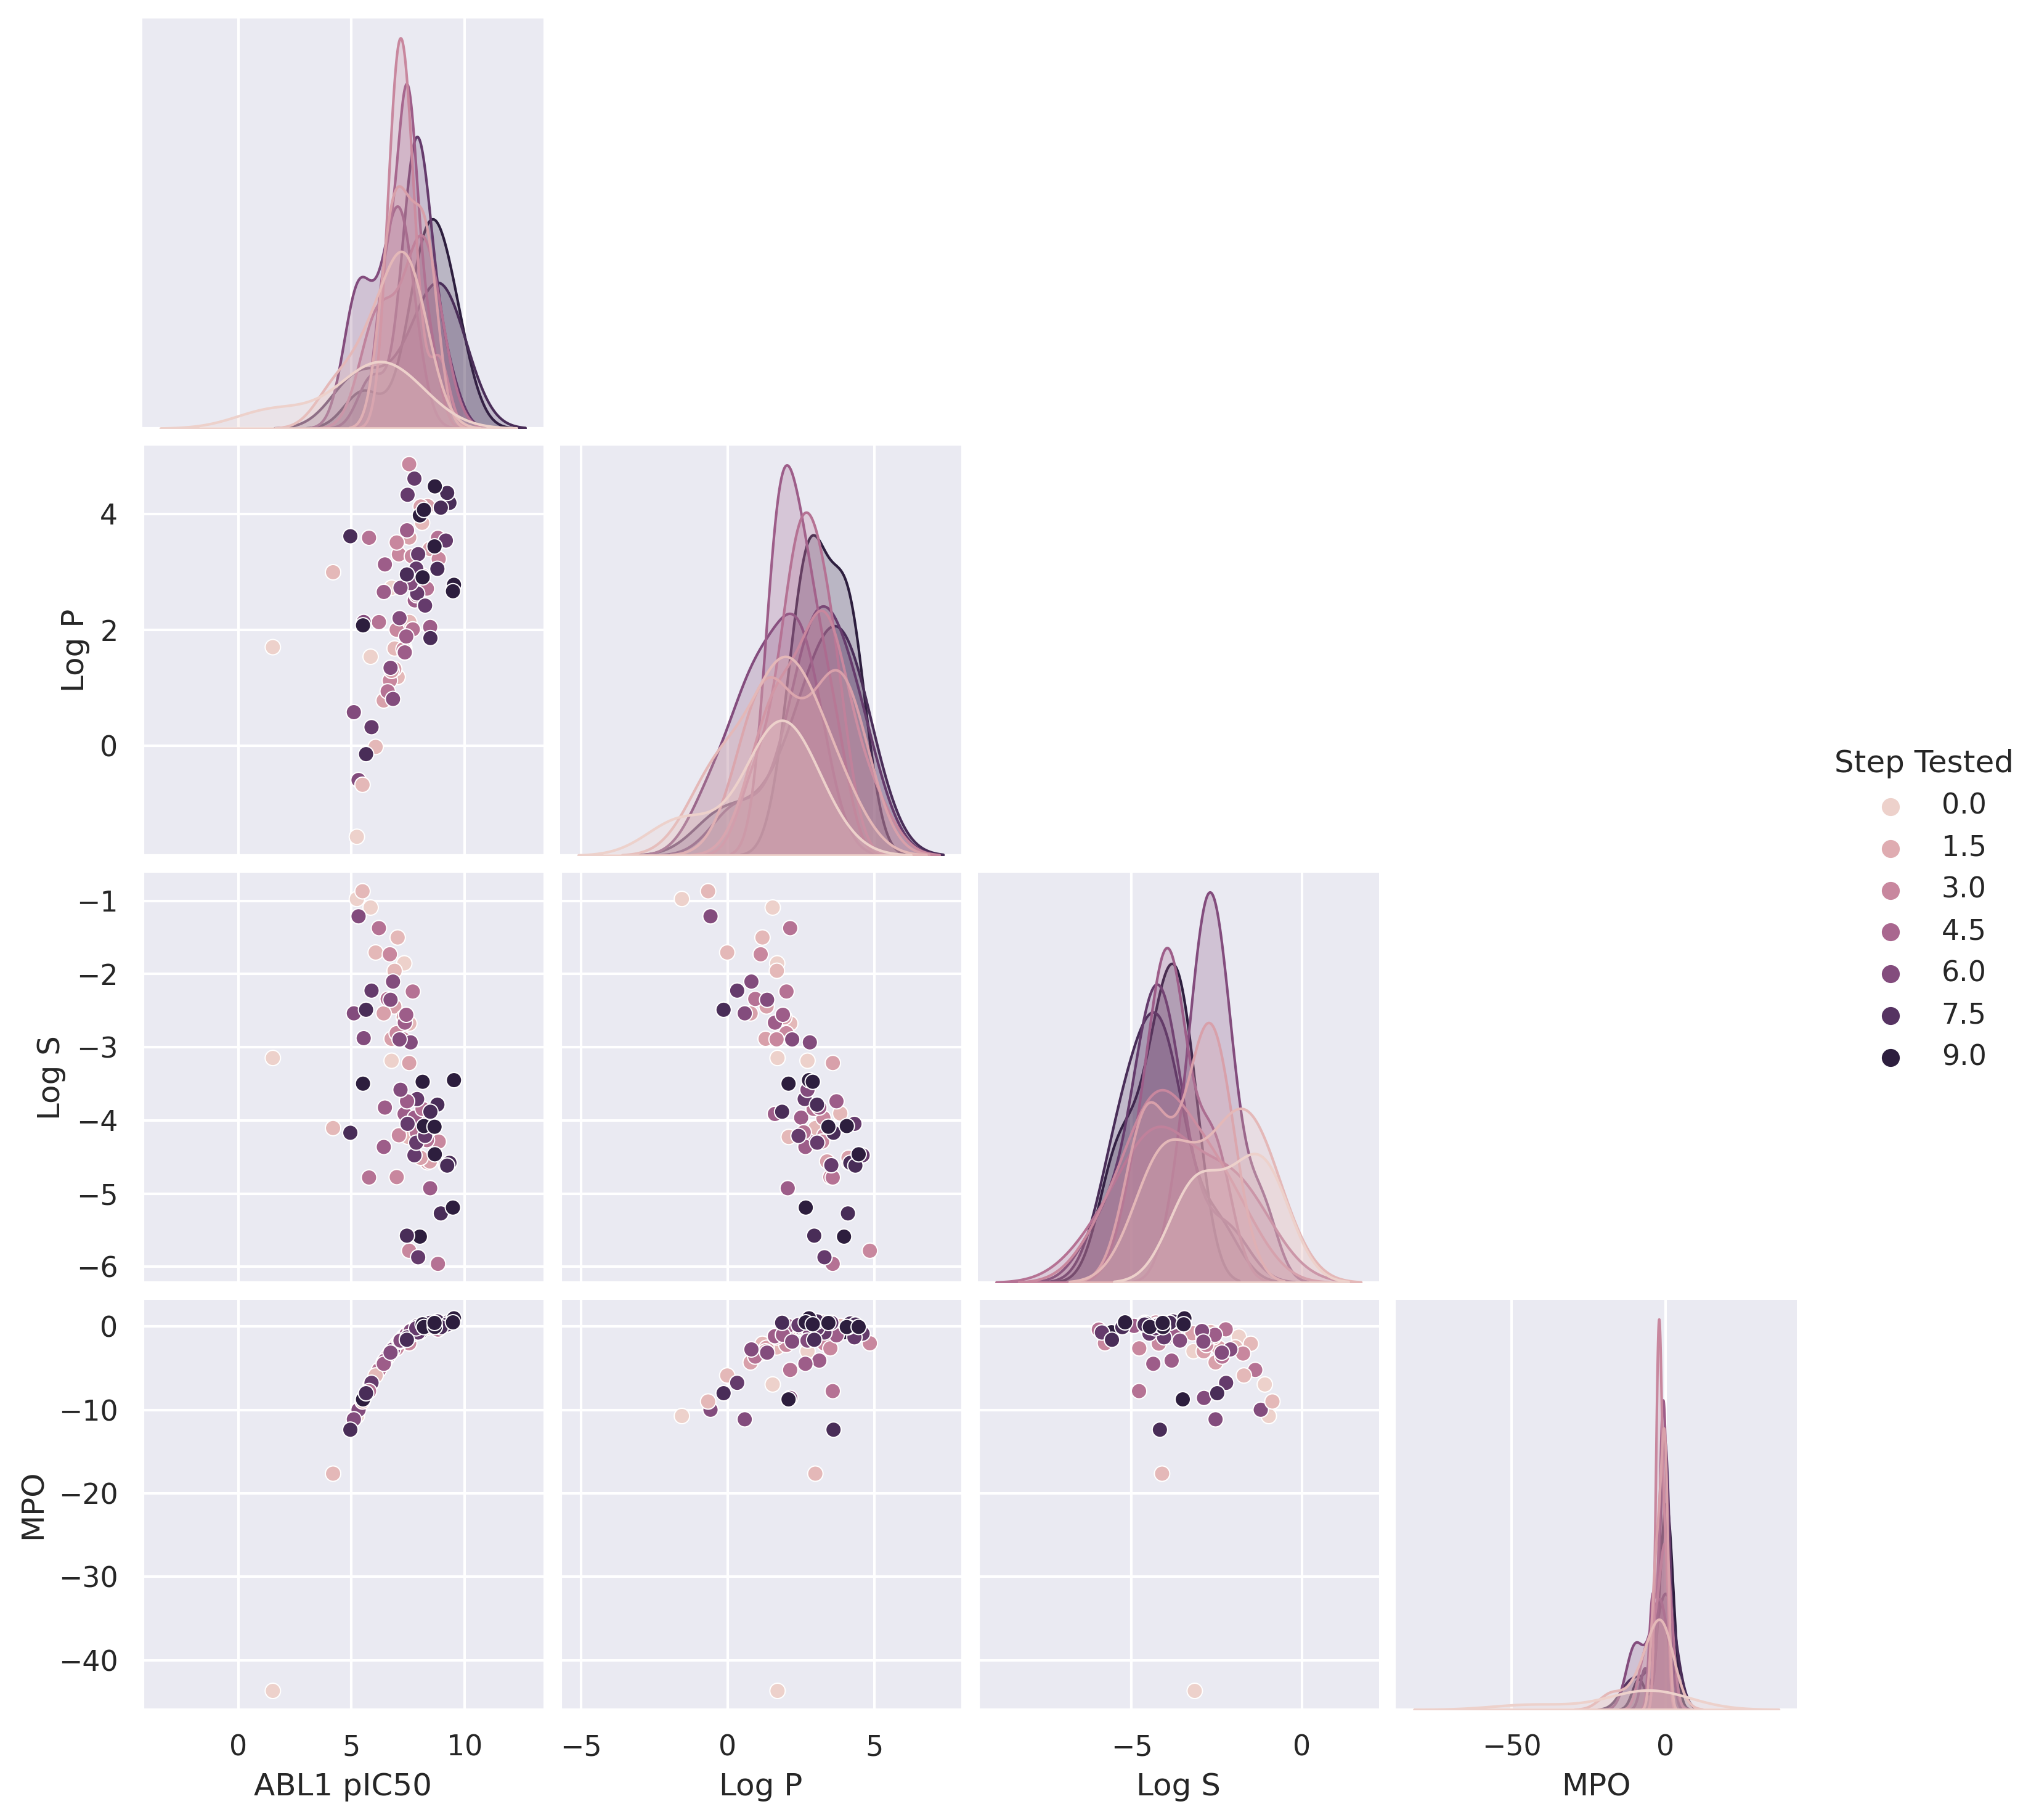

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(dpi=300)

pairplot_df = experiment.drug_env.library.annotations[
    ['ABL1 pIC50', 'Log P', 'Log S', 'Step Tested']
]

pairplot_df['MPO'] = experiment.drug_env.utility_function(drug_env.library, use_precomputed=True, method='average')

sns.set_theme()
g = sns.pairplot(
    pairplot_df,
    corner=True,
    hue='Step Tested'
)
g.fig.set_dpi(300)

In [45]:
max_timestep = int(experiment.drug_env.library.annotations['Step Tested'].max())

objective = 'ABL1 pIC50'
records = []
for timestep, group in pairplot_df.groupby('Step Tested'):
    for _, mol in group.iterrows():
        record = {
            'pIC50': mol[objective], 'Step Tested': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'Step Tested': int(t)})

df = pd.DataFrame(records)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

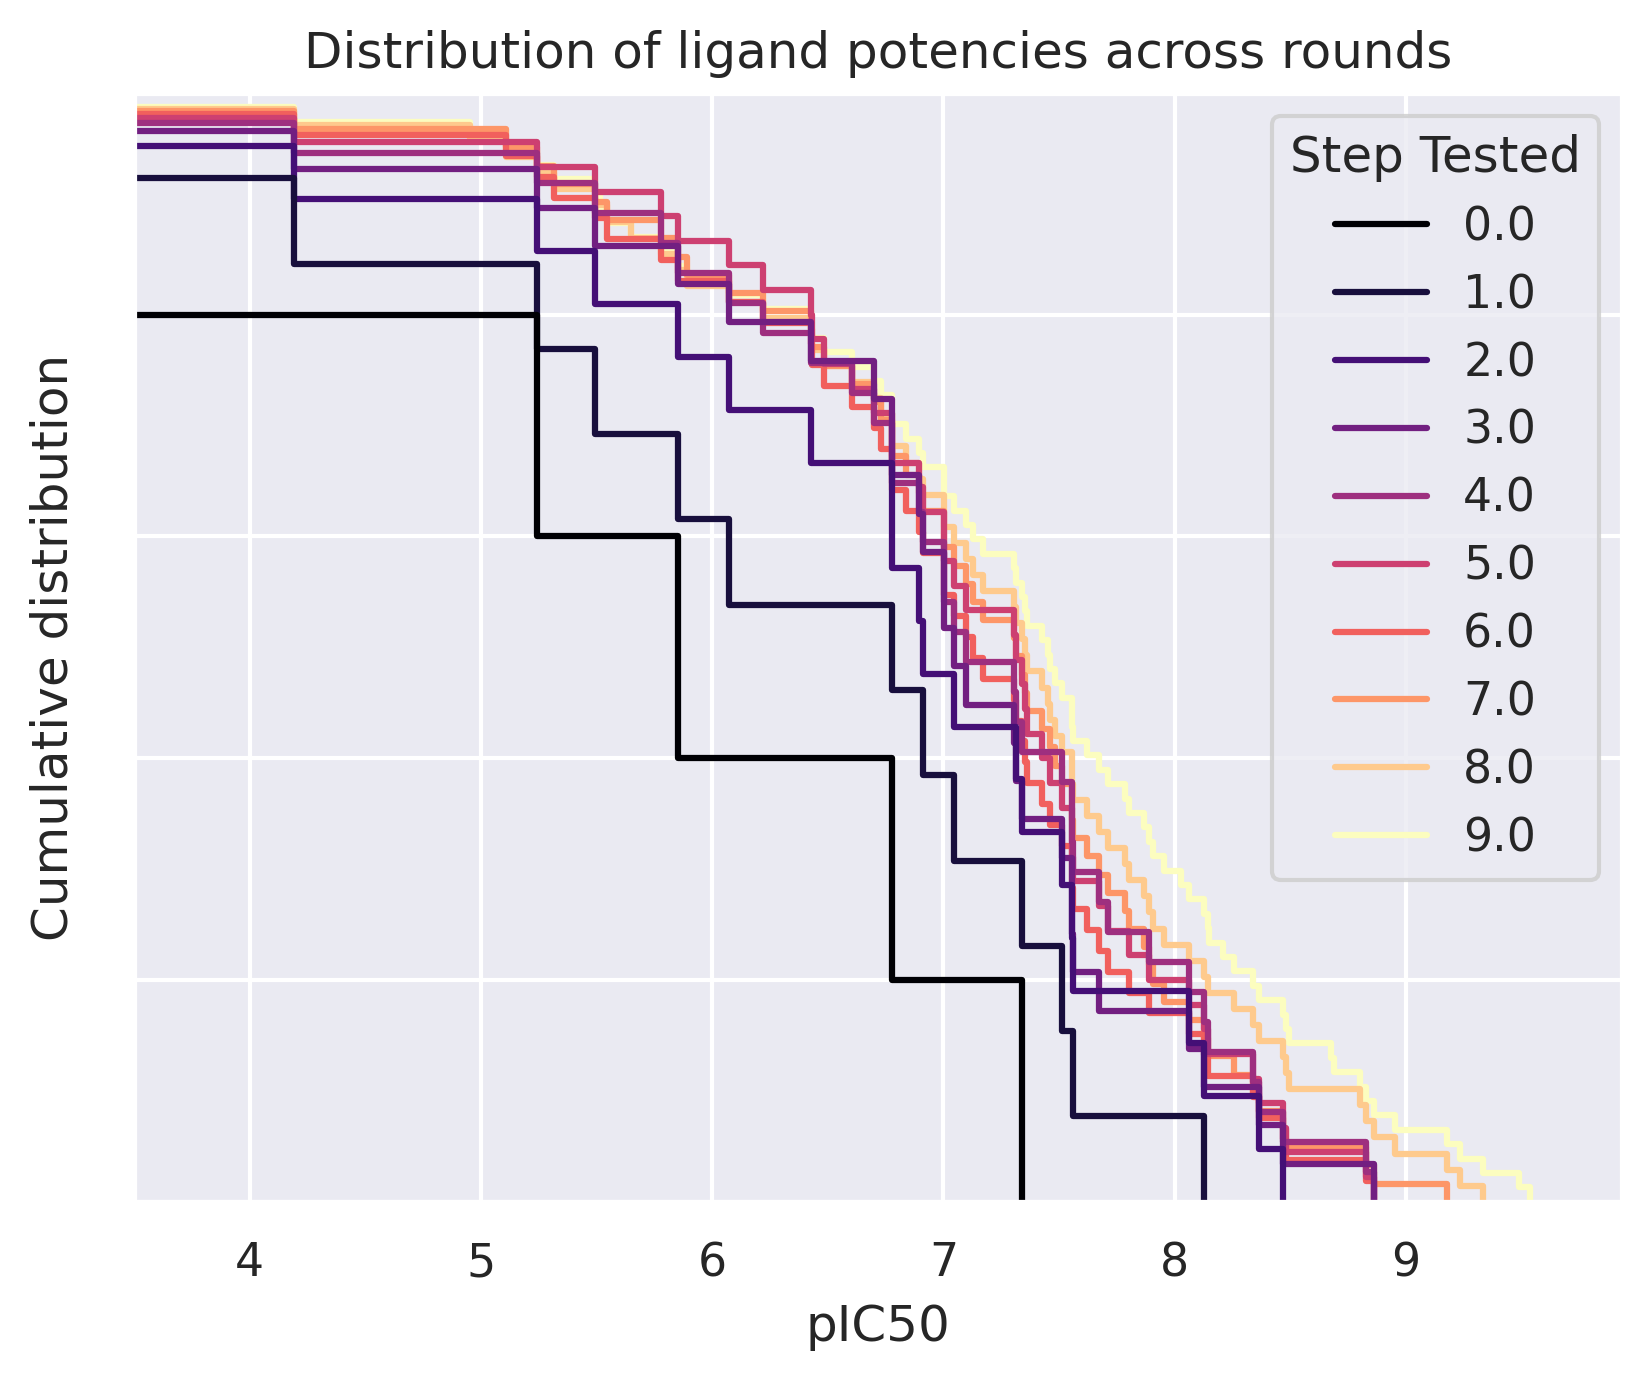

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(dpi=300)

g = sns.ecdfplot(
    df,
    x='pIC50',
    hue='Step Tested',
    palette='magma',
    complementary=True
)

g.set(yticklabels=[])

plt.xlim(3.5)
plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')

In [103]:
display_best(experiment)

,ABL1 pIC50,Log S,Log P,utility
628,9.535952,-3.449947,2.7765,1.000000
548,8.801921,-3.784695,3.0508,0.627691
632,9.489531,-5.190893,2.6659,0.514415
174,8.860971,-4.289783,3.2225,0.492830
552,8.493279,-3.881777,1.8589,0.463082


In [114]:
experiment.drug_env.library.tested.annotations.iloc[:,
    experiment.drug_env.library.tested.annotations.columns.str.contains('Step')
].tail(40)

,Step Tested,Step Designed,Step Scored,Step Made
232,4,2.0,2.0,4.0
239,8,3.0,3.0,8.0
240,5,3.0,3.0,5.0
245,4,3.0,3.0,4.0
246,4,3.0,3.0,4.0
248,4,3.0,3.0,4.0
251,4,3.0,3.0,4.0
272,4,3.0,3.0,4.0
315,9,3.0,3.0,9.0
318,5,4.0,4.0,5.0


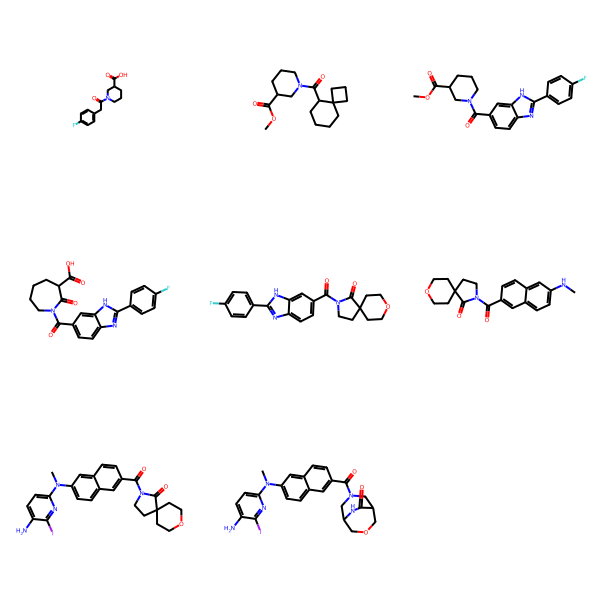

In [96]:
from rdkit.Chem.Draw import MolsToGridImage

lineage = experiment.drug_env.library[628].lineage

MolsToGridImage([l.mol for l in lineage])

In [119]:
lineage[-1].annotations

{'SMILES': 'CN(c1ccc2cc(C(=O)N3CC4COCC(C3)C(=O)N4)ccc2c1)c1ccc(N)c(I)n1',
 'Design Cycle': 0,
 'Reactants': "['CNc1ccc2cc(C(=O)N3CC4COCC(C3)C(=O)N4)ccc2c1', 'Nc1ccc(I)nc1I']",
 'Current Status': 'Tested',
 'Timestep': 9,
 'Step Designed': 8,
 'Inspiration': 'CN(c1ccc2cc(C(=O)N3CCC4(CCOCC4)C3=O)ccc2c1)c1ccc(N)c(I)n1',
 'Noisy ABL1 pIC50': 9.129009610549526,
 'Noisy Log S': -3.1841423700634763,
 'Noisy Log P': 3.297200189199674,
 'Step Scored': 8,
 'Step Made': 9,
 'ABL1 pIC50': 9.535951657682714,
 'Log S': -3.449947274988573,
 'Log P': 2.7765000000000004,
 'Step Tested': 9,
 'utility': 1.0}